In [33]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [101]:

hgrid = xr.open_dataset("/glade/u/home/manishrv/documents/nwa12_0.1/mom_input/n3b.clean/hgrid.nc")
ocean_geo = xr.open_dataset("/glade/u/home/manishrv/manish_scratch_symlink/n3b.clean/run/ocean_geometry.nc")
print(hgrid)

<xarray.Dataset> Size: 111MB
Dimensions:   (nyp: 1561, nxp: 1481, ny: 1560, nx: 1480)
Dimensions without coordinates: nyp, nxp, ny, nx
Data variables:
    tile      |S255 255B ...
    y         (nyp, nxp) float64 18MB ...
    x         (nyp, nxp) float64 18MB ...
    dy        (ny, nxp) float64 18MB ...
    dx        (nyp, nx) float64 18MB ...
    area      (ny, nx) float64 18MB ...
    angle_dx  (nyp, nxp) float64 18MB ...
Attributes:
    file_name:    ocean_hgrid.nc
    Description:  MOM6 NCAR NWA12
    Author:       Fred Castruccio (fredc@ucar.edu)
    Created:      2024-04-18T08:39:49.607481
    type:         MOM6 supergrid file


In [97]:
ocean_geo.lath

<xarray.DataArray 'lath' (lath: 780)> Size: 6kB
array([ 5.242669,  5.325648,  5.408616, ..., 53.820237, 53.85652 , 53.892753])
Coordinates:
  * lath     (lath) float64 6kB 5.243 5.326 5.409 5.492 ... 53.82 53.86 53.89
Attributes:
    long_name:       Latitude
    units:           degrees_north
    cartesian_axis:  Y

In [100]:
hgrid.y[:,0].values

array([ 5.20117513,  5.24266887,  5.28415984, ..., 52.74478451,
       52.76099408, 52.77719011])

In [35]:
k = 2
kp2 = k //2
offset_one_by_two_y = slice(kp2, len(hgrid.x.nyp),k)
offset_one_by_two_x = slice(kp2, len(hgrid.x.nxp),k)
by_two_x = slice(0, len(hgrid.x.nxp),k)
by_two_y = slice(0, len(hgrid.x.nyp),k)
t_points = (offset_one_by_two_y,offset_one_by_two_x)
u_points = (offset_one_by_two_y,by_two_x)
v_points = (by_two_y,offset_one_by_two_x)
q_points = (by_two_y,by_two_x)
tlon = hgrid.x[t_points]
tlat = hgrid.y[t_points]

# U point locations
ulon = hgrid.x[u_points]
ulat = hgrid.y[u_points]

# V point locations
vlon = hgrid.x[v_points]
vlat = hgrid.y[v_points]

# Corner point locations
qlon = hgrid.x[q_points]
qlat = hgrid.y[q_points]


In [36]:
qlon.shape

(781, 741)

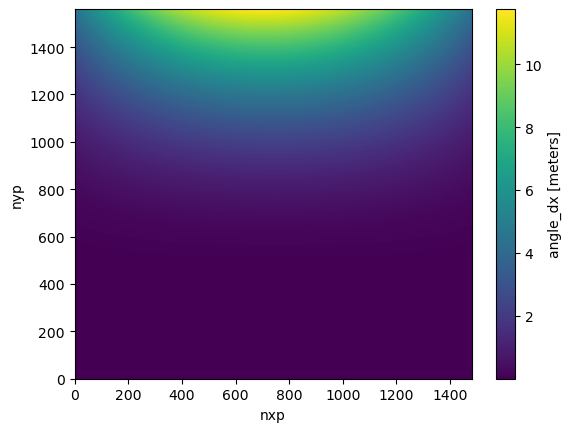

In [37]:
hgrid["angle_dx"].plot()

    pi_720deg = atan(1.0) / 180.0
    len_lon = 360.0 ; if (G%len_lon > 0.0) len_lon = G%len_lon
    do j=G%jsc,G%jec ; do i=G%isc,G%iec
      do n=1,2 ; do m=1,2
        lonB(m,n) = modulo_around_point(G%geoLonBu(I+m-2,J+n-2), G%geoLonT(i,j), len_lon)
      enddo ; enddo
      lon_scale = cos(pi_720deg*((G%geoLatBu(I-1,J-1) + G%geoLatBu(I,J)) + &
                                 (G%geoLatBu(I,J-1) + G%geoLatBu(I-1,J)) ) )
      angle = atan2(lon_scale*((lonB(1,2) - lonB(2,1)) + (lonB(2,2) - lonB(1,1))), &
                    (G%geoLatBu(I-1,J) - G%geoLatBu(I,J-1)) + &
                    (G%geoLatBu(I,J) - G%geoLatBu(I-1,J-1)) )
      G%sin_rot(i,j) = sin(angle) ! angle is the clockwise angle from lat/lon to ocean
      G%cos_rot(i,j) = cos(angle) ! grid (e.g. angle of ocean "north" from true north)

    function modulo_around_point(x, xc, Lx) result(x_mod)
      real, intent(in) :: x  !< Value to which to apply modulo arithmetic [A]
      real, intent(in) :: xc !< Center of modulo range [A]
      real, intent(in) :: Lx !< Modulo range width [A]
      real :: x_mod          !< x shifted by an integer multiple of Lx to be close to xc [A].

      if (Lx > 0.0) then
        x_mod = modulo(x - (xc - 0.5*Lx), Lx) + (xc - 0.5*Lx)
      else
        x_mod = x
      endif
    end function modulo_around_point

In [39]:
# Direct Translation
pi_720deg = np.arctan(1)/180 # One quarter the conversion factor from degrees to radians
 
## Check length of longitude
len_lon = 360.0
G_len_lon = hgrid.x.max() - hgrid.x.min()
if G_len_lon != 360:
    print("This is a regional case")
    len_lon = G_len_lon



This is a regional case


In [40]:
## Iterate it, j=G%jsc,G%jec ; do i=G%isc,G%iec mean we iterate from jsc to jec and isc to iec
## Then you iterate around it, 1,2 and 1,2

# In this way we wrap each longitude in the correct way even if we are at the seam like 360, I still don't understand it as much


def modulo_around_point(x, xc, Lx):
    """
    This function calculates the modulo around a point, for use in cases where we are wrapping around the globe at the seam. Return the modulo value of x in an interval [xc-(Lx/2) xc+(Lx/2)]. If Lx<=0, then it returns x without applying modulo arithmetic.
    Parameters
    ----------
    x: float
        Value to which to apply modulo arithmetic
    xc: float
        Center of modulo range
    Lx: float
        Modulo range width
    Returns
    -------
    float
        x shifted by an integer multiple of Lx to be close to xc, 
    """
    if Lx <= 0:
        return x
    else:
        return ((x - (xc - 0.5*Lx)) % Lx )- Lx/2 + xc



In [41]:
angles_arr_v2 = np.zeros((len(tlon.nyp), len(tlon.nxp)))

# Compute lonB for all points
lonB = np.zeros((2, 2, len(tlon.nyp), len(tlon.nxp)))

# Vectorized computation of lonB
for n in np.arange(0,2):
    for m in np.arange(0,2):
        lonB[m, n] = modulo_around_point(qlon[np.arange(m,(m-1+len(qlon.nyp))), np.arange(n,(n-1+len(qlon.nxp)))], tlon, len_lon)

# Compute lon_scale
lon_scale = np.cos(pi_720deg* ((qlat[0:-1, 0:-1] + qlat[1:, 1:]) + (qlat[1:, 0:-1] + qlat[0:-1, 1:])))



# Compute angle
angle = np.arctan2(
    lon_scale * ((lonB[0, 1] - lonB[1, 0]) + (lonB[1, 1] - lonB[0, 0])),
    (qlat[:-1, :-1] - qlat[1:, 1:]) + (qlat[1:, 0:-1] - qlat[0:-1, 1:])
)
# Assign angle to angles_arr
angles_arr_v2 =  np.rad2deg(angle) - 90
# Print the result
print(angles_arr_v2)

<xarray.DataArray 'y' (nyp: 780, nxp: 740)> Size: 5MB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.43651643, 4.47489525, 4.5132071 , ..., 4.40963338, 4.37648025,
        4.34327766],
       [4.45746382, 4.49601954, 4.53450787, ..., 4.429975  , 4.39669398,
        4.36336333],
       [4.47848207, 4.51721524, 4.5558806 , ..., 4.45038282, 4.41697365,
        4.38351466]])
Dimensions without coordinates: nyp, nxp


In [42]:
# Create the new DataArray with the new dimensions
t_angles = xr.DataArray(
    angles_arr_v2,
    dims=["qy", "qx"],
    coords={
        "qy": tlon.nyp.values,
        "qx": tlon.nxp.values,
    }
)



hgrid["t_angle_dx_mom6"] = t_angles
hgrid["t_angle_dx_mom6"].attrs["_FillValue"] = np.nan
hgrid["t_angle_dx_mom6"].attrs["units"] = "deg"
hgrid["t_angle_dx_mom6"].attrs["description"] = "MOM6 calculates angles internally, this field replicates that for rotating boundary conditions. Use this over other angle fields for MOM6 applications"


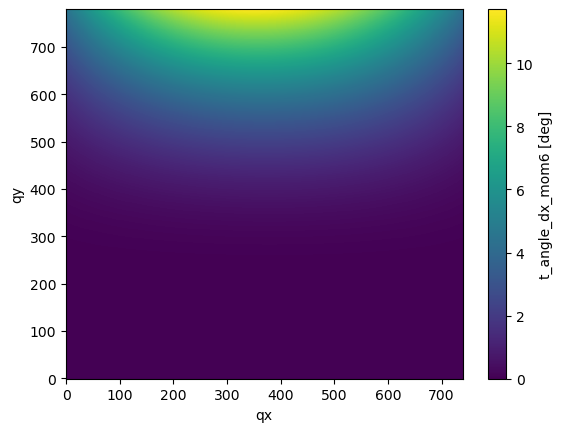

In [43]:
hgrid["t_angle_dx_mom6"].plot(vmin = 0)

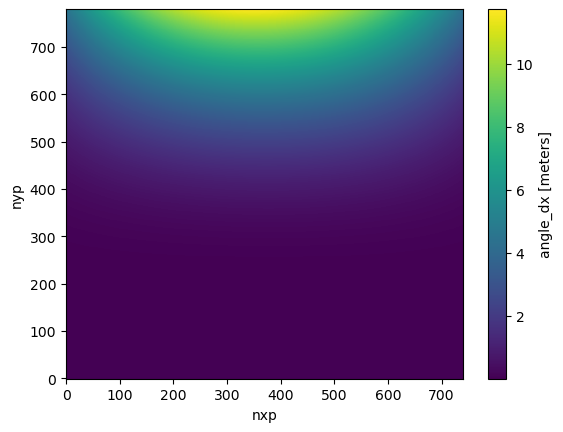

In [44]:
hgrid["angle_dx"][kp2::k,kp2::k].plot()

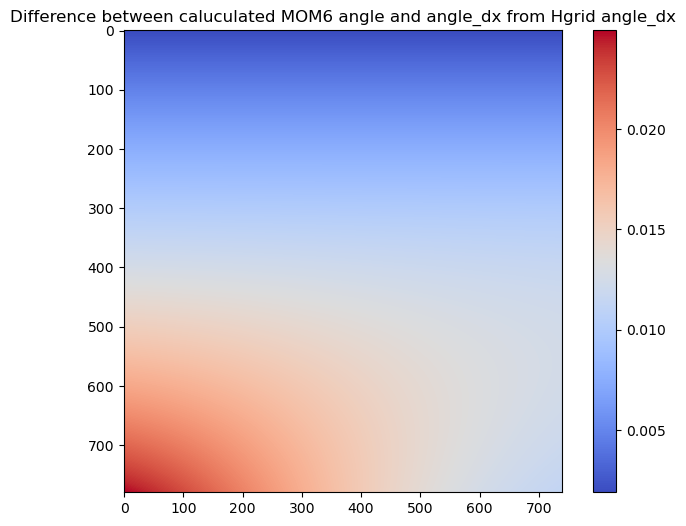

In [45]:
angle_diff = hgrid["angle_dx"][kp2::k,kp2::k].values - hgrid["t_angle_dx_mom6"].values
plt.figure(figsize=(8, 6))
plt.imshow(angle_diff,cmap='coolwarm')
plt.colorbar()
plt.title("Difference between caluculated MOM6 angle and angle_dx from Hgrid angle_dx")
plt.show()  

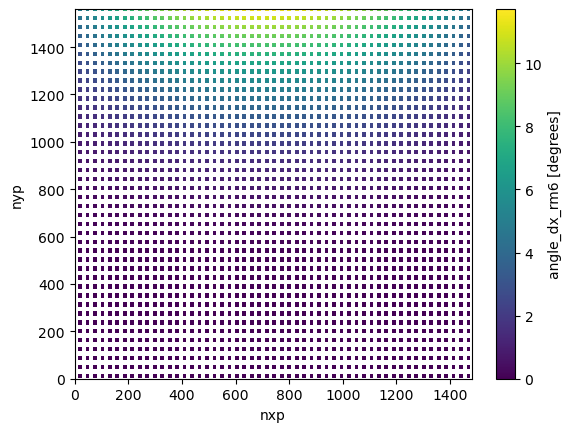

In [56]:
# Define a new angle field
hgrid["angle_dx_rm6"] = xr.full_like(hgrid.angle_dx, np.nan)
hgrid["angle_dx_rm6"].attrs["units"] = "degrees"
hgrid["angle_dx_rm6"][t_points] = hgrid["t_angle_dx_mom6"].values
hgrid["angle_dx_rm6"].plot()

### Apply XGCM Interpolation

In [47]:
import xgcm

In [104]:
# Define tpointx (xh) tpoint y (yh) qpoint x (xq) and qpoint y (yq) Hgrid to add XGCM required variables
xh_points = np.arange(kp2, len(hgrid.x.nxp),k)
yh_points = np.arange(kp2, len(hgrid.x.nyp),k)
xq_points = np.arange(0, len(hgrid.x.nxp),k)
yq_points = np.arange(0, len(hgrid.x.nyp),k)
xgcm_input = xr.Dataset(
    coords = {
        "xh": (("nyp","nxp"),tlon.values),
        "yh": (("nyp","nxp"),tlat.values),
        "xq": (("nyp_q","nxp_q"),qlon.values),
        "yq": (("nyp_q","nxp_q"),qlat.values),
    }
)
print(xgcm_input)
coords_mom6={'X':{'center':'xh', 'outer':'xq'}, 
        'Y':{'center':'yh','outer':'yq' }}
xgcm_hgrid = xgcm.Grid(xgcm_input, 
                        coords=coords_mom6, 
                        periodic = False)

<xarray.Dataset> Size: 18MB
Dimensions:  (nyp: 780, nxp: 740, nyp_q: 781, nxp_q: 741)
Coordinates:
    xh       (nyp, nxp) float64 5MB -97.96 -97.88 -97.79 ... -37.58 -37.49
    yh       (nyp, nxp) float64 5MB 5.243 5.243 5.243 ... 58.34 58.34 58.35
    xq       (nyp_q, nxp_q) float64 5MB -98.0 -97.92 -97.83 ... -37.54 -37.45
    yq       (nyp_q, nxp_q) float64 5MB 5.201 5.201 5.201 ... 58.37 58.37 58.38
Dimensions without coordinates: nyp, nxp, nyp_q, nxp_q
Data variables:
    *empty*


ValueError: Input `xh` (for the `center` position on axis `X`) is not a dimension in the input datasets `ds`.

In [49]:
# From Tutorial
grid = xgcm.Grid(ocean_geo, coords={'X': {'center': 'lonh', 'outer': 'lonq'},
                        'Y': {'center': 'lath', 'outer': 'latq'}}, periodic = False)
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   lonh --> outer
  * outer    lonq --> center
Y Axis (not periodic, boundary=None):
  * center   lath --> outer
  * outer    latq --> center

In [50]:
# Set up angle data...
t_angles = xr.DataArray(
    angles_arr_v2,
    dims=["lath", "lonh"],
    coords={
        "lath": ocean_geo.lath.values,
        "lonh": ocean_geo.lonh.values,
    }
)

t_angles


<xarray.DataArray 'y' (lath: 780, lonh: 740)> Size: 5MB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.43651643, 4.47489525, 4.5132071 , ..., 4.40963338, 4.37648025,
        4.34327766],
       [4.45746382, 4.49601954, 4.53450787, ..., 4.429975  , 4.39669398,
        4.36336333],
       [4.47848207, 4.51721524, 4.5558806 , ..., 4.45038282, 4.41697365,
        4.38351466]])
Coordinates:
  * lath     (lath) float64 6kB 5.243 5.326 5.409 5.492 ... 53.82 53.86 53.89
  * lonh     (lonh) float64 6kB -97.96 -97.88 -97.79 ... -36.54 -36.46 -36.38

In [90]:
# Interpolate....
angle_ds = xr.Dataset()
angle_ds["angle_dx_rm6_q"] = grid.interp(t_angles, axis=['X', 'Y'], to="outer", boundary = "extend")
angle_ds["angle_dx_rm6_v"] = grid.interp(t_angles, axis=[ 'Y'], to="outer", boundary = "extend")
angle_ds["angle_dx_rm6_u"] = grid.interp(t_angles, axis=[ 'X'], to="outer", boundary = "extend")

/glade/work/manishrv/conda-envs/CrocoDashDev/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [91]:
angle_ds

<xarray.Dataset> Size: 14MB
Dimensions:         (latq: 781, lonq: 741, lonh: 740, lath: 780)
Coordinates:
  * latq            (latq) float64 6kB 5.201 5.284 5.367 ... 53.84 53.87 53.91
  * lonq            (lonq) float64 6kB -98.0 -97.92 -97.83 ... -36.42 -36.33
  * lonh            (lonh) float64 6kB -97.96 -97.88 -97.79 ... -36.46 -36.38
  * lath            (lath) float64 6kB 5.243 5.326 5.409 ... 53.82 53.86 53.89
Data variables:
    angle_dx_rm6_q  (latq, lonq) float64 5MB 0.0 0.0 0.0 0.0 ... 4.434 4.4 4.384
    angle_dx_rm6_v  (latq, lonh) float64 5MB 0.0 0.0 0.0 ... 4.45 4.417 4.384
    angle_dx_rm6_u  (lath, lonq) float64 5MB 0.0 0.0 0.0 0.0 ... 4.434 4.4 4.384

In [92]:
hgrid["angle_dx_rm6"][u_points] = angle_ds["angle_dx_rm6_u"].values
hgrid["angle_dx_rm6"][v_points] = angle_ds["angle_dx_rm6_v"].values
hgrid["angle_dx_rm6"][q_points] = angle_ds["angle_dx_rm6_q"].values

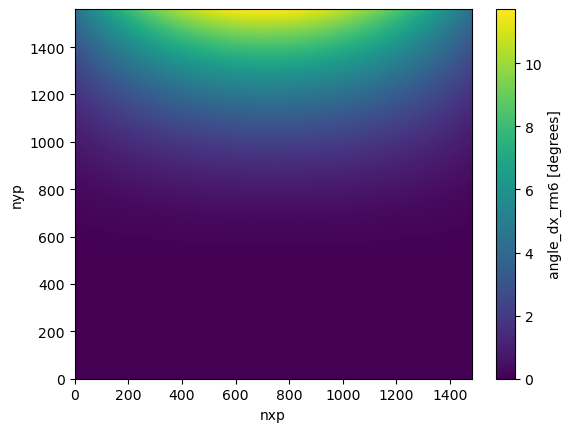

In [93]:
hgrid['angle_dx_rm6'].plot()

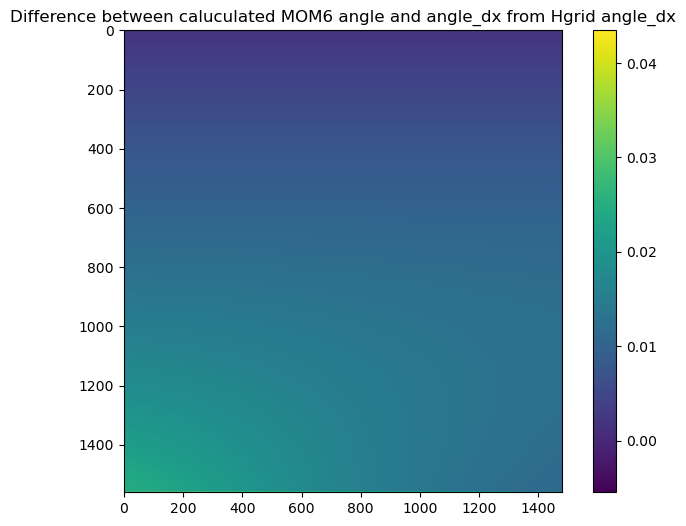

In [94]:
angle_diff = hgrid["angle_dx"] - hgrid["angle_dx_rm6"]
plt.figure(figsize=(8, 6))
plt.imshow(angle_diff)
plt.colorbar()
plt.title("Difference between caluculated MOM6 angle and angle_dx from Hgrid angle_dx")
plt.show()  

In [ ]:
# Looks like the interpolation is working reasonably except in the boundaries, we need to choose a specific angle

<xarray.DataArray (nyp: 1560, nxp: 1380)> Size: 17MB
array([[0.0018886 , 0.0018886 , 0.0018886 , ..., 0.0018886 , 0.0018886 ,
        0.0018886 ],
       [0.00190363, 0.00190363, 0.00190363, ..., 0.00190363, 0.00190363,
        0.00190363],
       [0.00191865, 0.00191865, 0.00191865, ..., 0.00191865, 0.00191865,
        0.00191865],
       ...,
       [0.02399983, 0.02397845, 0.02397953, ..., 0.01129944, 0.01130202,
        0.01129223],
       [0.02400675, 0.02398527, 0.02398634, ..., 0.01128624, 0.01128885,
        0.01127906],
       [0.0240375 , 0.02401598, 0.02401707, ..., 0.01128954, 0.01129214,
        0.01128232]])
Dimensions without coordinates: nyp, nxp